In [2]:
%pylab inline
%matplotlib inline
    
import pywt
import numpy as np
import seaborn
from statsmodels.robust import mad
import matplotlib.pyplot as plt  
import sys
import pandas as pd
import datetime
from dateutil.parser import parse


def waveletSmooth( x, wavelet="db4", level=1, title=None ):
    ''' smooth denoise'''
    # calculate the wavelet coefficients
    coeff = pywt.wavedec( x, wavelet, mode="per" )
    # calculate a threshold
    sigma = mad( coeff[-level] )
    # changing this threshold also changes the behavior,
    # but I have not played with this very much
    uthresh = sigma * np.sqrt( 2*np.log( len( x ) ) )
    coeff[1:] = ( pywt.threshold( i, value=uthresh, mode="soft" ) for i in coeff[1:] )
    # reconstruct the signal using the thresholded coefficients
    y = pywt.waverec( coeff, wavelet, mode="per" )
    return y

def read(filePath):
    '''
    read data 2 dict
    '''
    #!!!
    data = pd.read_csv(filePath)
    data['record_date'] = data['record_date'].apply(lambda x:parse(str(x)).strftime('%Y-%m-%d'))
    data['smooth'] = waveletSmooth(data['power_consumption'])
    
    #print data
    return data
            

def sumAll(data):
    '''sum by day'''
    dataSum = pd.DataFrame()
     
  
    dataSum['sum_consumption'] = data.groupby('record_date')['smooth'].sum() 

    dataSum['record_date'] = dataSum.index
    dataSum['week'] = dataSum['record_date'].apply(lambda x:datetime.datetime.strptime(x,'%Y-%m-%d').weekday())
    dataSum['month'] = dataSum['record_date'].apply(lambda x:datetime.datetime.strptime(x,'%Y-%m-%d').month)
    dataSum['day'] = dataSum['record_date'].apply(lambda x:datetime.datetime.strptime(x,'%Y-%m-%d').day)
  
    return dataSum
    
#  1.read and processdata   
dataRead = read("./data/Tianchi_power.csv")
dataRead.to_csv("./data/dataRead.csv",index=False)
print dataRead.head() 
# plot 
#f, ax = plt.subplots()
#plot( data['power_consumption'], color="b", alpha=0.5 )
#plot( data['smooth'], color="b" )

print("end")

Populating the interactive namespace from numpy and matplotlib
  record_date  user_id  power_consumption       smooth
0  2015-01-01        1               1135  1307.843253
1  2015-01-02        1                570   961.136028
2  2015-01-03        1               3418  3451.449113
3  2015-01-04        1               3968  3980.473372
4  2015-01-05        1               3986  3766.277368
end


In [25]:
# 2.sum
dataRead = pd.read_csv("./data/dataRead.csv")
dataInSum = sumAll(dataRead)
dataInSum.to_csv("./data/dataInSum.csv",index=False)
#print dataInSum.head()
# data =  dataInSum['sum_consumption'].values.tolist()
# plt.plot(data)
#f,ax = plt.subplots()
#plt.plot( dataInSum['sum_consumption'], color="b" )
#print('end')
#todo 识别突变点
#先滤波还是后滤波

# 

/Users/clz/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


          ds             y
0 2015-01-01  3.038432e+06
1 2015-01-02  3.245244e+06
2 2015-01-03  3.633776e+06
3 2015-01-04  3.952295e+06
4 2015-01-05  4.107242e+06


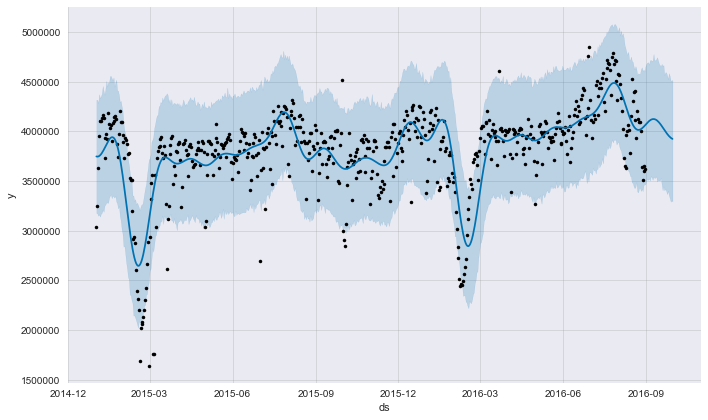

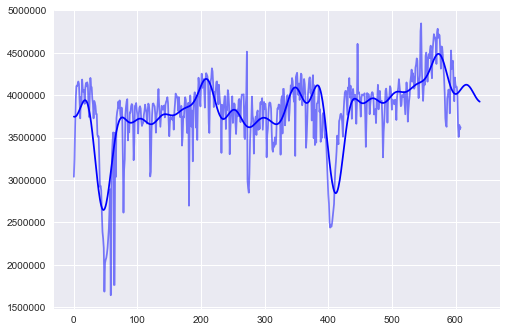

In [13]:
# 3 prophet 预测
import fbprophet as Prophet
dataInSum = pd.read_csv("./data/dataInSum.csv")
dataLog = dataInSum[['record_date','sum_consumption']]
dataLog['record_date'] = pd.DatetimeIndex(dataLog['record_date'])
# print dataLog.dtypes

# rename
dataLog = dataLog.rename(columns={'record_date': 'ds','sum_consumption': 'y'})

print dataLog.head()
# 
m = Prophet.Prophet(interval_width=0.95,yearly_seasonality=True,weekly_seasonality=False)
m.fit(dataLog)

future_dates = m.make_future_dataframe(periods=30)
future_dates.tail()

forecast = m.predict(future_dates)
#forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

#m.plot(forecast,uncertainty=True)

#f,ax = plt.subplots()
#plt.plot( dataInSum['sum_consumption'], color="b" ,alpha=0.5)
#plt.plot( forecast['yhat'], color="b" )


In [83]:
from sklearn import datasets, linear_model
from sklearn import preprocessing
# regression with temperature
# read wnedu
regressData=pd.DataFrame()
regressData = pd.read_csv("./data/zhenshitianqi.csv")[['date','max','min']]
# get history and forecast history
regressData['realValue'] = m.history['y'].values
history_dates = m.make_future_dataframe(periods=0)
regressData['hisroty_forecast'] = m.predict(history_dates)['yhat']
regressData.head()


,date,max,min,realValue,hisroty_forecast
0,2015/1/1,8,-4,3.038432e+06,3.747710e+06
1,2015/1/2,13,0,3.245244e+06,3.745899e+06
2,2015/1/3,16,3,3.633776e+06,3.747075e+06
3,2015/1/4,15,4,3.952295e+06,3.751253e+06
4,2015/1/5,10,2,4.107242e+06,3.758364e+06


('Coefficients: \n', array([ 0.95937029,  0.3285131 , -0.2815243 ]))
Mean squared error: 0.96
Variance score: -0.17
[ 1.99072072  1.96496809  1.71399061  1.28001814  0.92574828  0.3812094
 -0.46918677 -0.71120457 -0.76935593  0.20517408  0.33341047  0.50864809
  0.3587538  -0.30565027  0.76719233  1.85166526  1.220158    1.46655757
  1.49735963  0.64634381  0.11084784  0.92311167  0.68648955  0.59602651
  0.60123447  0.32592049 -0.74363941 -1.11904306 -0.70402663 -0.85537708
 -0.78954696]
[ 1.76217905  1.71399613  1.62533451  1.56746174  1.49801569  1.42335866
  1.36651256  1.30677336  1.1850263   1.07946463  1.04049823  0.95985957
  0.88787073  0.80960743  0.7420839   0.67548555  0.62121713  0.56328467
  0.54642717  0.53240865  0.41711458  0.45201109  0.49525734  0.49084255
  0.48731316  0.40275866  0.49327684  0.55495922  0.54835821  0.57714869
  0.61250726]


/Users/clz/anaconda/lib/python2.7/site-packages/sklearn/preprocessing/data.py:986: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/Users/clz/anaconda/lib/python2.7/site-packages/sklearn/preprocessing/data.py:1008: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/Users/clz/anaconda/lib/python2.7/site-packages/sklearn/preprocessing/data.py:986: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data 

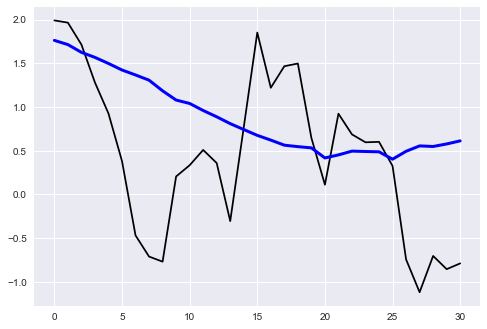

In [93]:
# regression

#scale
from sklearn.preprocessing import StandardScaler, RobustScaler
robust_scaler_x = RobustScaler()
robust_scaler_y = RobustScaler()
X = robust_scaler_x.fit_transform(regressData[['hisroty_forecast','max','min']])


# Split the data into training/testing sets
diabetes_X_train = X[:-31]
diabetes_X_test =X[-31:]


# Split the targets into training/testing sets
Y = robust_scaler_y.fit_transform( regressData['realValue'])
diabetes_y_train = Y[:-31]
diabetes_y_test = Y[-31:]

# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(diabetes_X_train, diabetes_y_train)

# The coefficients
print('Coefficients: \n', regr.coef_)
# The mean squared error
print("Mean squared error: %.2f"
      % np.mean((regr.predict(diabetes_X_test) - diabetes_y_test) ** 2))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % regr.score(diabetes_X_test, diabetes_y_test))

# Plot validation outputs
print(diabetes_y_test)
print(regr.predict(diabetes_X_test))
plt.plot(diabetes_y_test,  color='black')
plt.plot(regr.predict(diabetes_X_test), color='blue',
         linewidth=3)
plt.show()

/Users/clz/anaconda/lib/python2.7/site-packages/sklearn/preprocessing/data.py:986: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/Users/clz/anaconda/lib/python2.7/site-packages/sklearn/preprocessing/data.py:1063: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


ds    datetime64[ns]
dtype: object
    predict_date  predict_power_consumption
609     20160901                    4127151
610     20160902                    4144756
611     20160903                    4141041
612     20160904                    4147788
613     20160905                    4149512
614     20160906                    4129300
615     20160907                    4148739
616     20160908                    4153238
617     20160909                    4170931
618     20160910                    4160520
619     20160911                    4161414
620     20160912                    4156604
621     20160913                    4150027
622     20160914                    4128609
623     20160915                    4075644
624     20160916                    4070335
625     20160917                    4080816
626     20160918                    4081110
627     20160919                    4069633
628     20160920                    4048290
629     20160921                    40211

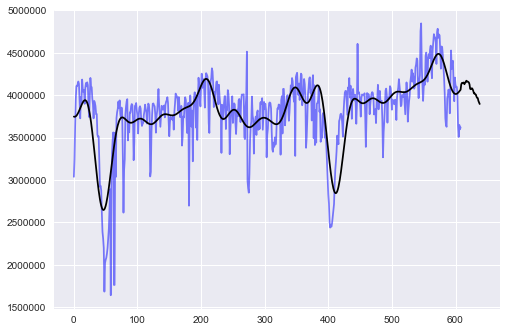

In [115]:
# 
# add regress 
regressionForecastData = pd.read_csv('./data/201609扬中市天气预报.csv')[['date','max','min']][:30]

#prop预测的九月数据
history_dates = m.make_future_dataframe(periods=30)
history_dates = history_dates[-30:]
regressionForecastData['hisroty_forecast'] = m.predict(history_dates)['yhat']

#regression 预测
#print regressionForecastData[['hisroty_forecast','max','min']]
X = robust_scaler_x.transform(regressionForecastData[['hisroty_forecast','max','min']])
Y = regr.predict(X)
predict_data = robust_scaler_y.inverse_transform(Y)

#print  
endForecast =  list(forecast['yhat'].values[:-30]) + list(predict_data)
f,ax = plt.subplots()
plt.plot(dataInSum['sum_consumption'], color="b" ,alpha=0.5)
plt.plot(endForecast,  color='black')

#save
endPre = pd.DataFrame()
print history_dates.dtypes
endPre['predict_date'] = history_dates['ds'].apply(lambda x:parse(str(x)).strftime('%Y%m%d'))
endPre['predict_power_consumption']=map(np.int,predict_data)
print endPre
endPre.to_csv('./data/Tianchi_power_predict_table.csv',index=False)